In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from skimage import io
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from monai.networks import one_hot
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
from skimage import io, transform
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import nibabel as nib
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
import img2pdf
from torchmetrics import F1Score

from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM, medsam_inference
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

### Run this once only for any new model

In [41]:
checkpoint = '/gpfs/home/kn2347/loss_reweighted_results_7-31-23/MedSAM_finetune_hcp_ya_constant_bbox_all_tasks-20230804-133537/medsam_model_best.pth'
convert_medsam_checkpt_to_readable_for_sam(checkpoint, to_save_dir = '/gpfs/home/kn2347/results/models_8-9-23/scratch_loss_reweighted_lr1e-4_ce_only_longer3_model_20230804-133537/model_best.pth')

{'image_encoder.pos_embed': tensor([[[[-0.2320, -0.1851, -0.1300,  ...,  0.7461,  0.6950,  0.7883],
           [-0.0565, -0.1099, -0.0843,  ...,  0.7280,  0.7802,  0.6967],
           [ 0.0266, -0.0061,  0.0291,  ...,  0.6569,  0.6624,  0.6768],
           ...,
           [ 0.3665, -0.0974, -0.3686,  ...,  0.7141,  0.7225,  0.7463],
           [ 0.4368,  0.0055, -0.3741,  ...,  0.7529,  0.7490,  0.7087],
           [ 0.5442,  0.0770, -0.3220,  ...,  0.6976,  0.7023,  0.8418]],
 
          [[-0.1500, -0.1262, -0.1068,  ...,  0.7246,  0.7330,  0.6920],
           [-0.0452, -0.0979,  0.0041,  ...,  0.6478,  0.6891,  0.6555],
           [ 0.0543,  0.0652,  0.0446,  ...,  0.6864,  0.7072,  0.7170],
           ...,
           [ 0.2924, -0.1278, -0.4692,  ...,  0.7465,  0.7653,  0.6969],
           [ 0.3947, -0.0293, -0.4074,  ...,  0.6894,  0.7592,  0.6865],
           [ 0.4407, -0.0707, -0.3906,  ...,  0.6854,  0.6983,  0.6661]],
 
          [[-0.1819, -0.1185, -0.0977,  ...,  0.7624,  0.75

### Run from here

In [3]:
# run on single task case
checkpoint = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_evaluating_models_first_pass_7-22-23/model_1e-4_best.pth'
device = 'cuda:0'
sam_model = sam_model_registry['vit_b'](checkpoint=checkpoint).to(device)
sam_model.eval()

path_df_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv'
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'
train_dataset, val_dataset, test_dataset = load_datasets(path_df_path, train_test_splits_path, label_id = 2, bbox_shift=0, sample_n_slices = None)


Initializing with no label converter, are you sure the labels are correct?
Initializing with no label converter, are you sure the labels are correct?
Initializing with no label converter, are you sure the labels are correct?


In [7]:
def run_model_on_dataset(model, test_ds, mask_empty_class_images_with_nan, dest_H=256, dest_W=256, model_trained_on_multi_label=False):
    # output should be pandas dataframe with paths to segmentations, as well as summary stats (e.g. dice scores w.r.t. ground truth)
    dataloader = DataLoader(
        test_ds,
        batch_size = 16,
        shuffle = False,
        num_workers = 0,
        pin_memory = True
    )
    list_ids = []
    list_slice_nums = []
    stats_lists = {'dice_score_with_ground_truth':[]}
    class_dice_collector = []
    for step, (image_embedding, gt2D, boxes, slice_names) in enumerate(tqdm(dataloader)):

        image_embedding, gt2D, boxes = image_embedding.cuda(), gt2D.cuda(), boxes.cuda()
        #print(gt2D.shape)
        medsam_pred = torch.as_tensor(medsam_inference(model, image_embedding, boxes, dest_H, dest_W, as_one_hot=True, model_trained_on_multi_label=model_trained_on_multi_label), dtype=torch.uint8).cuda()

        
        # numpy (B, C, 256, 256)

        #print(gt2D.shape) # tensor of size (B, 1, 256, 256)
        
        #medsam_pred = seg_get_class_indices(medsam_pred) # now (batches, classes, 256, 256)
        
        # generate stats here
        dice_scores = dice_scores_multi_class(medsam_pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan=mask_empty_class_images_with_nan) # (B, C)

        #dice_scores = dice_score_single_class(gt2D, medsam_pred, eps=1e-6) #mask_empty_class_images_with_nan=mask_empty_class_images_with_nan)

        class_dice_collector.append(dice_scores)
    
    val_class_dices = torch.cat(class_dice_collector, dim=0).nanmean(dim=0)
    
    return val_class_dices
    

#class_dices = run_model_on_dataset(sam_model, val_dataset, mask_empty_class_images_with_nan=False, #model_trained_on_multi_label = False) # 0.9411
#print(class_dices)
#print(sum(stats_list['dice_score_with_ground_truth']) / len(stats_list['dice_score_with_ground_truth']))



In [ ]:
class_dices = run_model_on_dataset(sam_model, val_dataset, mask_empty_class_images_with_nan=False, model_trained_on_multi_label = False)
# 0.9411

In [37]:
class_dices2 = run_model_on_dataset(sam_model, val_dataset, mask_empty_class_images_with_nan=True, model_trained_on_multi_label = False)
# 0.8653


100%|██████████| 888/888 [30:34<00:00,  2.07s/it]


In [8]:
checkpoint = '/gpfs/home/kn2347/results/models_8-9-23/scratch_loss_reweighted_lr1e-4_ce_only_longer3_model_20230804-133537/model_best.pth'

device = 'cuda:0'


df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)

sam_model = build_sam_vit_b_multiclass(num_classes=NUM_CLASSES, checkpoint=checkpoint).to(device)

path_df_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv'
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'
train_dataset, val_dataset, test_dataset = load_datasets(path_df_path, train_test_splits_path, label_id = None, bbox_shift=0, label_converter=label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=False)

In [9]:
class_dices3 = run_model_on_dataset(sam_model, val_dataset, mask_empty_class_images_with_nan=True, model_trained_on_multi_label = True)

100%|██████████| 1776/1776 [1:21:29<00:00,  2.75s/it]


In [18]:
names = label_converter.compressed_to_name(list(range(103)))
dices = class_dices3
dfo = pd.DataFrame({'name':names, 'dice score': dices})
dfo = dfo.sort_values(['dice score'])
dfo.to_csv('/gpfs/home/kn2347/results/models_8-9-23/scratch_loss_reweighted_lr1e-4_ce_only_longer3_model_20230804-133537/scratch_loss_reweighted_lr1e-4_ce_only_longer3_validation_dice_scores_1.6million_samples.csv')

In [67]:
path_df = pd.read_csv(path_df_path)

mxo = -1
for i in range(1000):
    seg_path = path_df.loc[i,'segmentation_slice_path']
    mxo = max(mxo, np.load(seg_path).max())

0
(256, 256, 256)
0
1
(256, 256, 256)
0
2
(256, 256, 256)
(256, 256, 256)
0
3
(256, 256, 256)
0
4
(256, 256, 256)
290


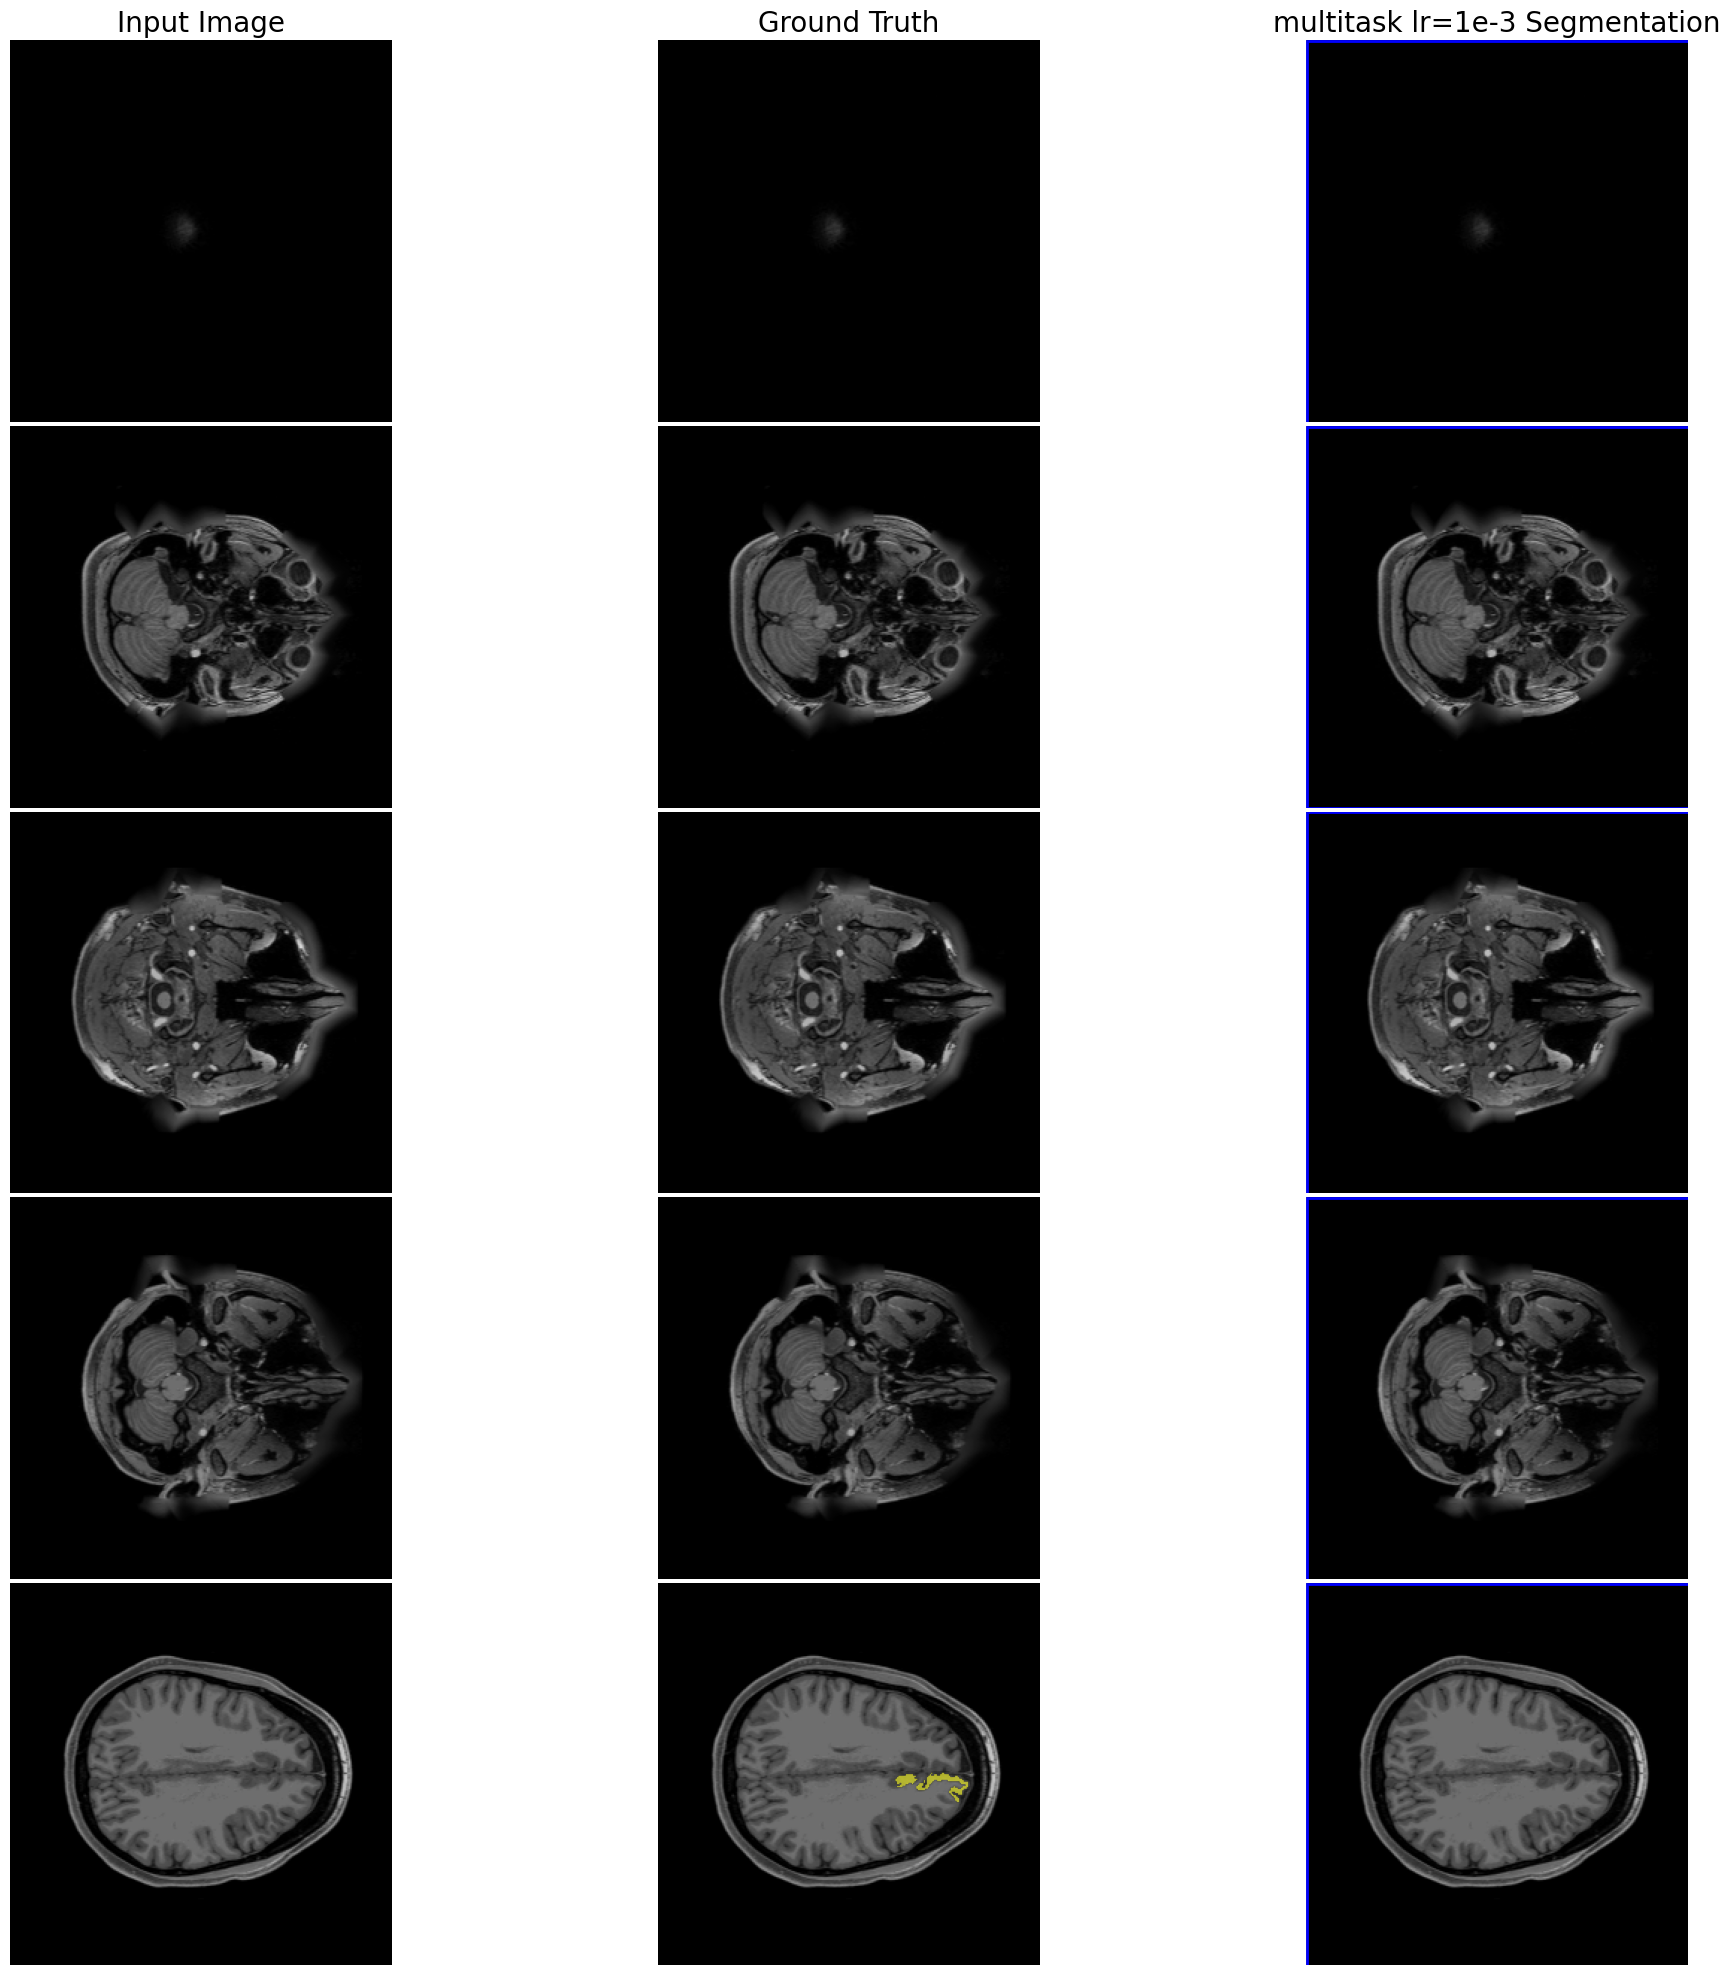

In [56]:
fig, axs, seg_list = plot_random_example(test_dataset, [sam_model], ['multitask lr=1e-3'], label_to_viz=4, dev='cuda', dest_H=256, dest_W=256, n_ex=5, restrict_to_label_present=True, seed = 182, debug=True)